In [1]:
import transformers
import torch 
import torch.optim as optim
import matplotlib.pyplot as plt

import os
import numpy as np
import imageio.v3 as iio
import re
import einops
import tqdm

/autofs/space/saffron_001/users/catherine_gai/anaconda3/envs/cs297r/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ChildImageDataset(torch.utils.data.Dataset): 
    def __init__(self, root_folder, type="train"): 
        super().__init__()
        np.random.seed(297)
        self.root_folder = root_folder 
        img_names = \
            sorted([os.path.splitext(f)[0] for f in os.listdir(self.root_folder) if "scene" in f and ".png" in f])
        self.valid_img_names = []
        for img_name in img_names: 
            if img_name + ".txt" in os.listdir(root_folder): 
                self.valid_img_names.append(img_name)
        self.valid_img_names = sorted(self.valid_img_names)
        np.random.shuffle(self.valid_img_names)
        train_len = int(0.8 * len(self.valid_img_names))
        val_len = (len(self.valid_img_names) - train_len) // 2

        if type == "train":
            self.img_names = self.valid_img_names[:train_len]
        elif type == "val": 
            self.img_names = self.valid_img_names[train_len: train_len + val_len]
        elif type == "test": 
            self.img_names = self.valid_img_names[train_len + val_len:]
        
    def __len__(self): 
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        x = iio.imread(os.path.join(self.root_folder, self.img_names[idx] + ".png")) / 255.
        gt_file = open(os.path.join(self.root_folder, self.img_names[idx] + ".txt"), "r")
        lines = gt_file.readlines()
        assert len(lines) == 1
        y = [float(re.findall(r".*: ([0-9\.]*)", lines[0])[0])]
        x, y = torch.Tensor(x), torch.Tensor(y)
        x = einops.rearrange(x, 'h w c -> c h w')
        return x, y


In [3]:
class ChildSubjectDataset(torch.utils.data.Dataset): 
    def __init__(self, root_folder, type="train", view=90): 
        super().__init__()
        np.random.seed(297)
        self.root_folder = root_folder 
        self.view = str(view).rjust(3, "0")

        img_names = \
            sorted([os.path.splitext(f)[0] for f in os.listdir(self.root_folder) if "scene" in f and ".png" in f])
        self.valid_img_names = []
        for img_name in img_names: 
            if img_name + ".txt" in os.listdir(root_folder): 
                self.valid_img_names.append(img_name)

        self.valid_subject_names = list(set([n.split("_")[0] for n in self.valid_img_names]))
        self.valid_subject_names = sorted(self.valid_subject_names)
        
        np.random.shuffle(self.valid_subject_names)
        train_len = int(0.8 * len(self.valid_subject_names))
        val_len = (len(self.valid_subject_names) - train_len) // 2

        if type == "train":
            self.subject_names = self.valid_subject_names[:train_len]
        elif type == "val": 
            self.subject_names = self.valid_subject_names[train_len: train_len + val_len]
        elif type == "test": 
            self.subject_names = self.valid_subject_names[train_len + val_len:]
        
    def __len__(self): 
        return len(self.subject_names)

    def __getitem__(self, idx):
        subject_name = self.subject_names[idx]
        img_name = "_".join([subject_name, self.view])
        x = iio.imread(os.path.join(self.root_folder, img_name + ".png")) / 255.
        gt_file = open(os.path.join(self.root_folder, img_name + ".txt"), "r")
        lines = gt_file.readlines()
        assert len(lines) == 1
        y = [float(re.findall(r".*: ([0-9\.]*)", lines[0])[0])]
        x, y = torch.Tensor(x), torch.Tensor(y)
        x = einops.rearrange(x, 'h w c -> c h w')
        return x, y


In [4]:
class LinearHead(torch.nn.Module): 
    def __init__(self, input_dim, hidden_features, output_dim): 
        super().__init__()
        self.hidden_features = hidden_features
        self.output_dim = output_dim

        self.layer_list = []

        input_dim = input_dim
        for feature in hidden_features: 
            self.layer_list.append(torch.nn.Linear(input_dim, feature))
            self.layer_list.append(torch.nn.PReLU())
            input_dim = feature 
        self.layer_list.append(torch.nn.Linear(hidden_features[-1], output_dim))

        self.layer_list = torch.nn.ModuleList(self.layer_list)
    
    def forward(self, x): 
        for layer in self.layer_list:
            x = layer(x)
        return x


In [5]:
dataset_train = ChildImageDataset(root_folder="/homes/1/sg1526/misc/data", type="train")
dataset_val = ChildImageDataset(root_folder="/homes/1/sg1526/misc/data", type="val")
print(dataset_train[0][0].shape)

torch.Size([3, 512, 512])


In [6]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=8, shuffle=True)

Training loss: 5599.539301757813
Validation loss: 5713.549278846154
Training loss: 5420.176689453125
Validation loss: 5254.536395733173
Training loss: 4222.775517578125
Validation loss: 2944.914118840144
Training loss: 1092.2199870300292
Validation loss: 146.86520532461313
Training loss: 1788.9829920959473
Validation loss: 1306.4087946965144
Training loss: 416.10958616256715
Validation loss: 931.5990224984976
Training loss: 1666.5615405273438
Validation loss: 2291.055607722356
Training loss: 2189.8811584472655
Validation loss: 1957.5349778395432
Training loss: 1132.6576086425782
Validation loss: 316.4698991041917
Training loss: 396.4931066608429
Validation loss: 1390.8384775015024
Training loss: 1698.6649978637695
Validation loss: 550.9979905348557
Training loss: 228.99074138641356
Validation loss: 657.7235764723557
Training loss: 1262.1917236328125
Validation loss: 1827.5549879807693
Training loss: 1912.8466967773438
Validation loss: 1937.888174203726
Training loss: 1532.6773455810546

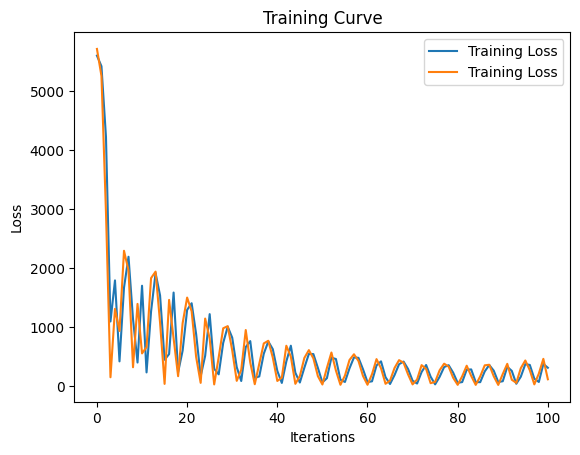

Training loss: 39.8139013338089
Validation loss: 77.92449217576247
Training loss: 220.83213081359864
Validation loss: 398.61780724158655
Training loss: 463.87944274902344
Validation loss: 502.3213336651142
Training loss: 380.27517669677735
Validation loss: 238.39688814603366
Training loss: 84.80300625324249
Validation loss: 18.158844214219314
Training loss: 151.09929307341577
Validation loss: 374.3108825683594
Training loss: 483.07383728027344
Validation loss: 444.1314392089844
Training loss: 212.46155105590822
Validation loss: 28.672334304222694
Training loss: 69.5944128894806
Validation loss: 221.2937985933744
Training loss: 388.21710189819333
Validation loss: 548.1926879882812
Training loss: 541.7127575683594
Validation loss: 484.4165485088642
Training loss: 288.9232495117187
Validation loss: 105.73340078500601
Training loss: 44.17455075263977
Validation loss: 119.63418226975661
Training loss: 362.7723812103271
Validation loss: 598.2600614107572
Training loss: 495.23616668701175
Val

KeyboardInterrupt: 

In [9]:
from transformers import ViTConfig, ViTModel, ViTImageProcessor
configuration = ViTConfig(image_size=224, patch_size=16)
model = ViTModel.from_pretrained('google/vit-base-patch16-224', add_pooling_layer=False,
                                 cache_dir="/autofs/space/saffron_001/users/catherine_gai/misc/model_weights")
linear_head = LinearHead(input_dim=768, hidden_features=[256, 128, 64, 32, 8], output_dim=1)
preprocessor = ViTImageProcessor(do_resize=True, size={"height": 224, "width": 224}, 
                                 do_rescale=False, do_normalize=False)

lr = 0.00003
optimizer = optim.Adam(linear_head.parameters(), lr=lr)
num_iters = 1000

best_validation_loss = np.inf
linear_weight_save_folder = "/autofs/space/saffron_001/users/catherine_gai/misc/trained_weights/trainbyimage"
if not os.path.exists(linear_weight_save_folder):
    os.makedirs(linear_weight_save_folder, exist_ok=False)
linear_weight_save_name = "googlevitbase_patch16-224_linearhead"

training_losses = [] 
validation_losses = []
for iter in range(num_iters):
    training_losses_it = []
    for batch in dataloader_train: 
        x, y = batch 
        x = preprocessor.preprocess(x, return_tensors="pt", 
                                    data_format="channels_first", input_data_format="channels_first")
        with torch.no_grad():
            outputs = model(**x)
            # print(outputs.last_hidden_state.shape)
        outputs = linear_head(outputs.last_hidden_state[:, 0])
        # print(outputs.shape)
        # print(outputs)

        loss = ((y - outputs) ** 2).mean()
        training_losses_it.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Training loss:", np.array(training_losses_it).mean())
    training_losses.append(np.array(training_losses_it).mean())

    linear_head.eval()
    validation_losses_it = []
    for batch in dataloader_val: 
        x, y = batch 
        x = preprocessor.preprocess(x, return_tensors="pt", 
                                    data_format="channels_first", input_data_format="channels_first")
        with torch.no_grad():
            outputs = model(**x)
        outputs = linear_head(outputs.last_hidden_state[:, 0])
        loss = ((y - outputs) ** 2).mean()
        validation_losses_it.append(loss.item())
    print("Validation loss:", np.array(validation_losses_it).mean())
    if np.array(validation_losses_it).mean() < best_validation_loss: 
        best_validation_loss = np.array(validation_losses_it).mean()
        torch.save(linear_head.state_dict(), os.path.join(linear_weight_save_folder, linear_weight_save_name + f"best_{iter}_loss{best_validation_loss}.pth"))
    validation_losses.append(np.array(validation_losses_it).mean())
    linear_head.train()

    if iter > 0 and iter % 100 == 0: 
        plt.plot(np.arange(iter + 1), training_losses, label = "Training Loss")
        plt.plot(np.arange(iter + 1), validation_losses, label = "Training Loss")
        plt.legend()
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title("Training Curve")
        plt.show()
        plt.close()
    

In [77]:
dataset_train = ChildSubjectDataset(root_folder="/homes/1/sg1526/misc/data", type="train")
dataset_val = ChildSubjectDataset(root_folder="/homes/1/sg1526/misc/data", type="val")
print(dataset_train[0][0].shape)

torch.Size([3, 512, 512])


In [82]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=8, shuffle=False)

In [8]:
from transformers import ViTConfig, ViTModel, ViTImageProcessor
configuration = ViTConfig(image_size=224, patch_size=16)
model = ViTModel.from_pretrained('google/vit-base-patch16-224', add_pooling_layer=False,
                                 cache_dir="/autofs/space/saffron_001/users/catherine_gai/misc/model_weights")
linear_head = LinearHead(input_dim=768, hidden_features=[256, 128, 64, 32, 8], output_dim=1)
preprocessor = ViTImageProcessor(do_resize=True, size={"height": 224, "width": 224}, 
                                 do_rescale=False, do_normalize=False)

lr = 0.00003
optimizer = optim.Adam(linear_head.parameters(), lr=lr)
num_iters = 1000

best_validation_loss = np.inf
linear_weight_save_folder = "/autofs/space/saffron_001/users/catherine_gai/misc/trained_weights/trainbysubject"
if not os.path.exists(linear_weight_save_folder):
    os.makedirs(linear_weight_save_folder, exist_ok=False)
linear_weight_save_name = "googlevitbase_patch16-224_linearhead"

training_losses = [] 
validation_losses = []
for iter in range(num_iters):
    print(f"Iter {iter} >>>>>>>>>>>>>>>")
    training_losses_it = []
    for batch in dataloader_train: 
        x, y = batch 
        x = preprocessor.preprocess(x, return_tensors="pt", 
                                    data_format="channels_first", input_data_format="channels_first")
        with torch.no_grad():
            outputs = model(**x)
            # print(outputs.last_hidden_state.shape)
        outputs = linear_head(outputs.last_hidden_state[:, 0])
        # print(outputs.shape)
        # print(outputs)

        loss = ((y - outputs) ** 2).mean()
        training_losses_it.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Training loss:", np.array(training_losses_it).mean())
    training_losses.append(np.array(training_losses_it).mean())

    linear_head.eval()
    validation_losses_it = []
    for batch in dataloader_val: 
        x, y = batch 
        x = preprocessor.preprocess(x, return_tensors="pt", 
                                    data_format="channels_first", input_data_format="channels_first")
        with torch.no_grad():
            outputs = model(**x)
        outputs = linear_head(outputs.last_hidden_state[:, 0])
        loss = ((y - outputs) ** 2).mean()
        validation_losses_it.append(loss.item())
    print("Validation loss:", np.array(validation_losses_it).mean())
    if np.array(validation_losses_it).mean() < best_validation_loss: 
        best_validation_loss = np.array(validation_losses_it).mean()
        torch.save(linear_head.state_dict(), os.path.join(linear_weight_save_folder, linear_weight_save_name + f"best_{iter}_loss{best_validation_loss}.pth"))
    validation_losses.append(np.array(validation_losses_it).mean())
    linear_head.train()

    if iter % 100 == 0: 
        plt.plot(np.arange(iter), training_losses, label = "Training Loss")
        plt.plot(np.arange(iter), validation_losses, label = "Training Loss")
        plt.legend()
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title("Training Curve")
        plt.show()
    

Iter 0 >>>>>>>>>>>>>>>
Training loss: 5605.585888671875


KeyboardInterrupt: 